In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x96/*.npy .
!cp -r gdrive/My\ Drive/tools/ .
!cp -r gdrive/My\ Drive/models/ .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 5994972
drwx------ 3 root root       4096 Apr 29 16:39 gdrive
drwx------ 2 root root       4096 Apr 29 16:41 models
drwxr-xr-x 1 root root       4096 Apr 26 16:21 sample_data
drwx------ 3 root root       4096 Apr 29 16:41 tools
-rw------- 1 root root  818509952 Apr 29 16:39 X_test.npy
-rw------- 1 root root 2619205760 Apr 29 16:40 X_train.npy
-rw------- 1 root root  654815360 Apr 29 16:40 X_val.npy
-rw------- 1 root root  409255040 Apr 29 16:40 y_test.n

In [0]:
!cp gdrive/My\ Drive/14/after_50/tmp.csv .
!cp gdrive/My\ Drive/14/after_50/weights5 .

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
import tools._my_tools as mt
import tools._torch_tools as tt
from models.loss import CombinedLoss
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
X_train, X_val = mt.loadDataByOne("",train=True,val=True,typeF='float16',channels_last=False)

Device is cuda:0
Loading X_train.npy
Loading y_train.npy
Loading X_val.npy
Loading y_val.npy


In [0]:
import torchvision

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv2 = self._convBlock(1, 2, **self.conv_setup)
        self.conv4 = self._convBlock(2, 4, **self.conv_setup)
        self.conv8 = self._convBlock(4, 8, **self.conv_setup)
        self.conv16 = self._convBlock(8, 16, **self.conv_setup)
        
        self.conv16_16 = self._convBlock(16, 16, **self.conv_setup)

        self.upsample16 = self._upsampleBlock(self.upsample_layer, 16, 16, **self.conv_setup)
        self.deconv8 = self._convBlock(16, 8, **self.conv_setup)
        self.upsample8 = self._upsampleBlock(self.upsample_layer, 8, 8, **self.conv_setup)
        self.deconv4 = self._convBlock(8, 4, **self.conv_setup)
        self.upsample4 = self._upsampleBlock(self.upsample_layer, 4, 4, **self.conv_setup)
        self.deconv2 = self._convBlock(4, 2, **self.conv_setup)
        self.upsample2 = self._upsampleBlock(self.upsample_layer, 2, 2, **self.conv_setup)
        self.deconv1 = self._convBlock(2, 1, kernel=(3,3), stride=(1,1), padding=1, activation=None)
    
    def encode(self, x):
        x2 = self.conv2(x)
        x2_p = self.pooling_layer(x2)
        
        x4 = self.conv4(x2_p)
        x4_p = self.pooling_layer(x4)
        
        x8 = self.conv8(x4_p)
        x8_p = self.pooling_layer(x8)
        
        x16 = self.conv16(x8_p)
        x16_p = self.pooling_layer(x16)
        
        return x16_p
    
    def decode(self,x):
        x = self.conv16_16(x)
        
        x = self.upsample16(x)
        x = self.deconv8(x)
        
        x = self.upsample8(x)
        x = self.deconv4(x)
        
        x = self.upsample4(x)
        x = self.deconv2(x)
        
        x = self.upsample2(x)
        x = self.deconv1(x)

        return x
        
    def forward(self, x):
        x = self.encode(x)

        x = self.decode(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        )
        if activation is not None:
            net = nn.Sequential(
                net, 
                nn.BatchNorm2d(out_channels),
                activation
            )
        return net
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )

# model = Model().to(device)

# if device == torch.device("cpu"):
#     print(summary(model, (1,96,96)))
# else:
#     print(summary(model.cuda(), (1,96,96)))

In [5]:
model = Model()
model.load_state_dict(torch.load("weights5"))
# loss = VggLoss(0.00002)
loss = CombinedLoss()
training = tt.Training(model, device, X_train, X_train, X_val, X_val, loss_function=loss)

training.history = mt.fromCSV("tmp.csv")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:08, 70014734.82it/s]


In [10]:
try:
    training.fit(128, 5, val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")

====== HYPERPARAMETERS ======
batch_size : 128
epochs : 5
loss function : CombinedLoss(
  (vgg): VggLoss(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[1](2220/2220): Loss: 0.0413	ETA 0:00:01	Epoch Loss: 0.0388
Epoch[1] finished in 0:26:10 with loss 0.038767295428090265
Validating on 71040 samples.
===> Validating (555/555):	ETA 0:00:00	Validation Loss: 0.0393
Validation loss = 0.0393

----------------------------

===> Epoch[2](2220/2220): Loss: 0.0412	ETA 0:00:01	Epoch Loss: 0.0386
Epoch[2] finished in 0:26:05 with loss 0.03863989412113353
Validating on 71040 samples.
===> Validating (555/555):	ETA 0:00:00	Validation Loss: 0.0395
Validation loss = 0.0395

----------------------------

===> Epoch[3](2220/2220): Loss: 0.0409	ETA 0:00:01	Epoch Loss: 0.0386
Epoch[3] finished in 0:26:05 with loss 0.03858079755393503
Validating on 71040 samples.
===> Validating (555/555):	ETA 0:00:00	Validation Loss: 0.0387
Validation loss = 0.0387

----------------------------

===> Epoch[4](2220/2220): Loss: 0.0411	ETA 0:00:01	Epoch Loss: 0.0385
Epoch[4] finished in 0:26:01 with loss 0.0384953294704492
Validating on 71040 samples.
===> Valida

In [0]:
from shutil import copyfile

for i in range(1,11):
    copyfile("weights"+str(i),"gdrive/My\ Drive/14/after_50/weights"+str(i))

mt.toCSV("tmp.csv",training.history)
copyfile("tmp.csv", "gdrive/My\ Drive/14/after_50/tmp.csv")
    
# !cp weights* gdrive/My\ Drive/14/.
# mt.toCSV("tmp.csv",training.history)
# !cp tmp.csv gdrive/My\ Drive/14/.

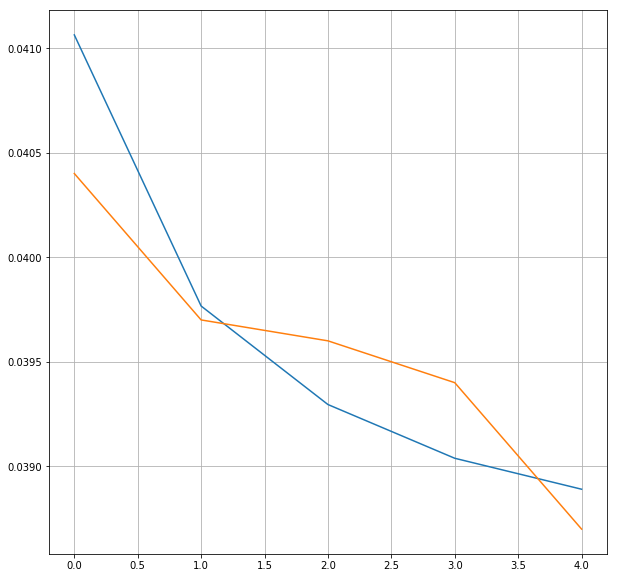

In [6]:
mt.plotHistory(training.history)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


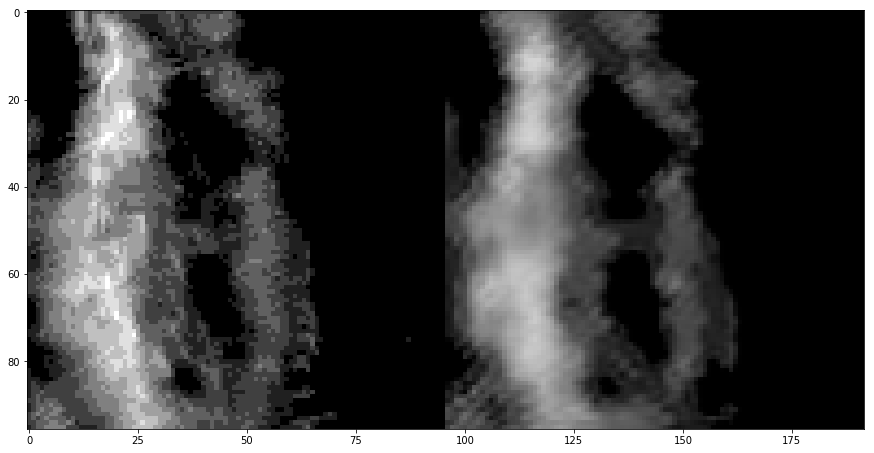

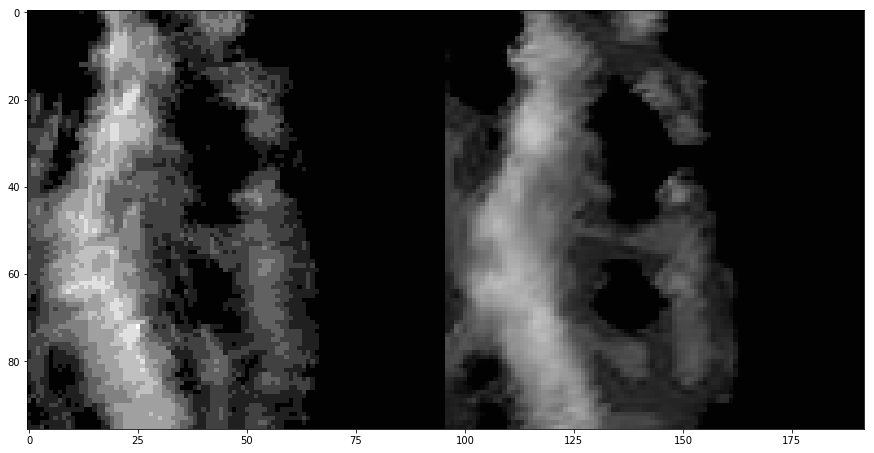

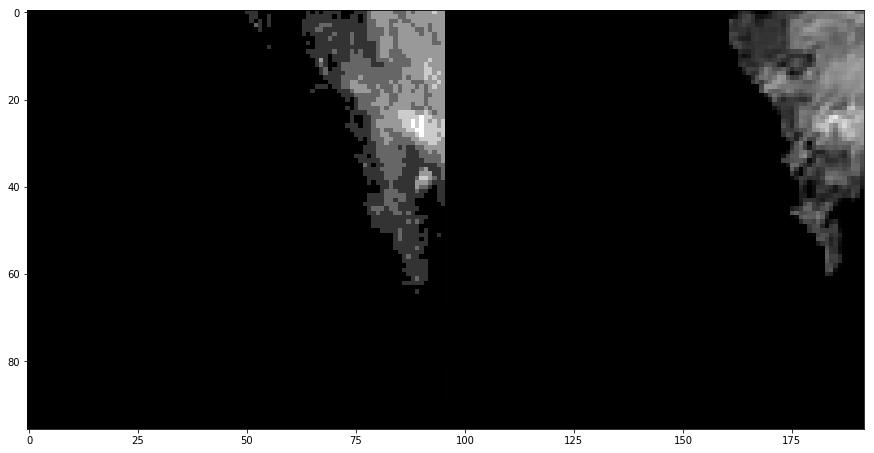

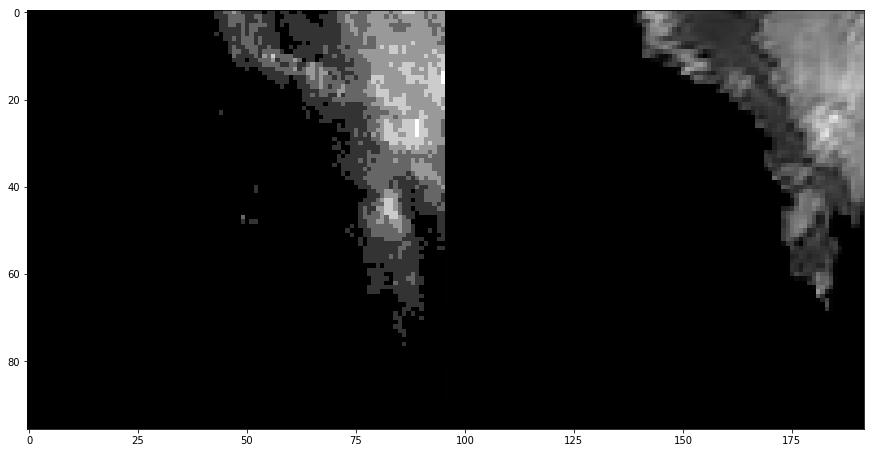

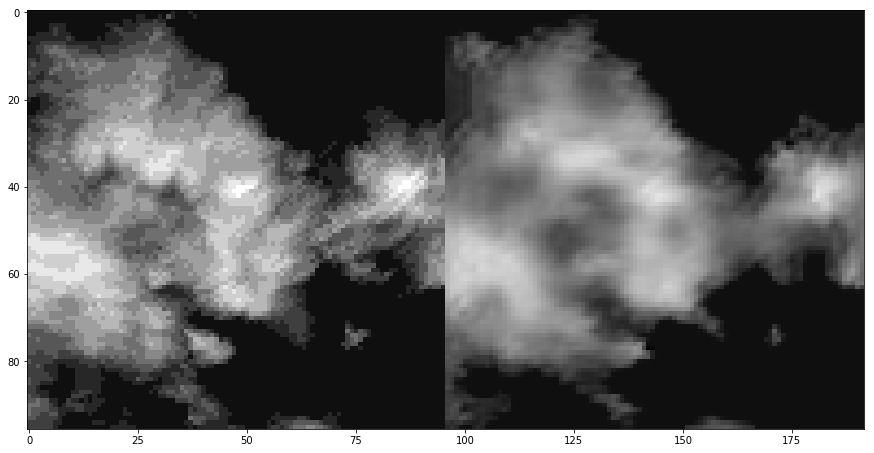

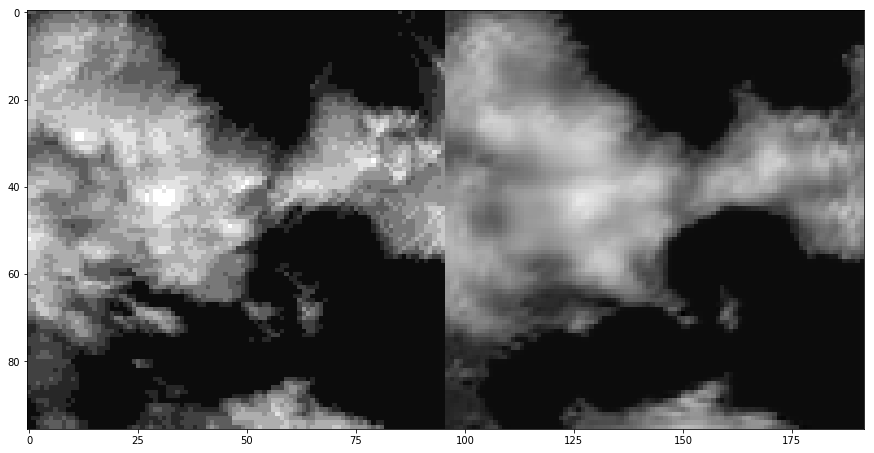

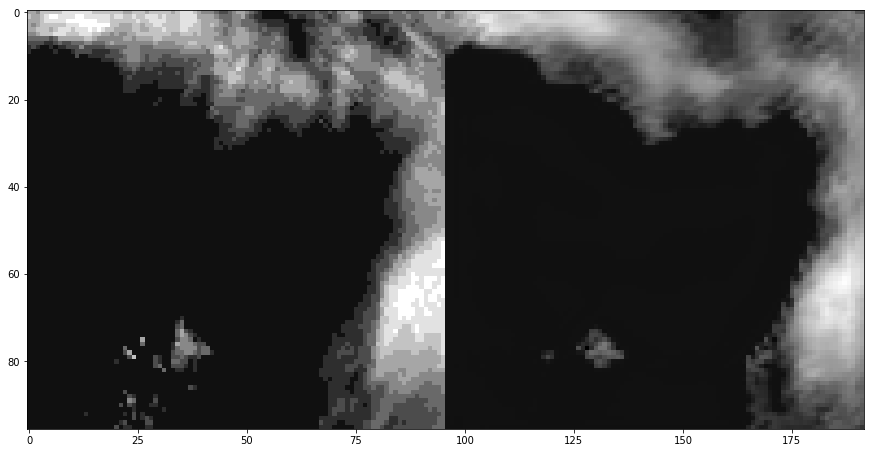

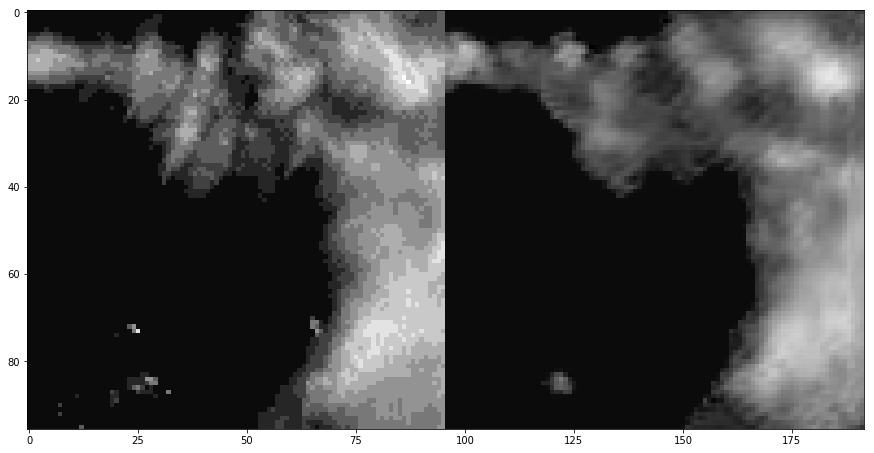

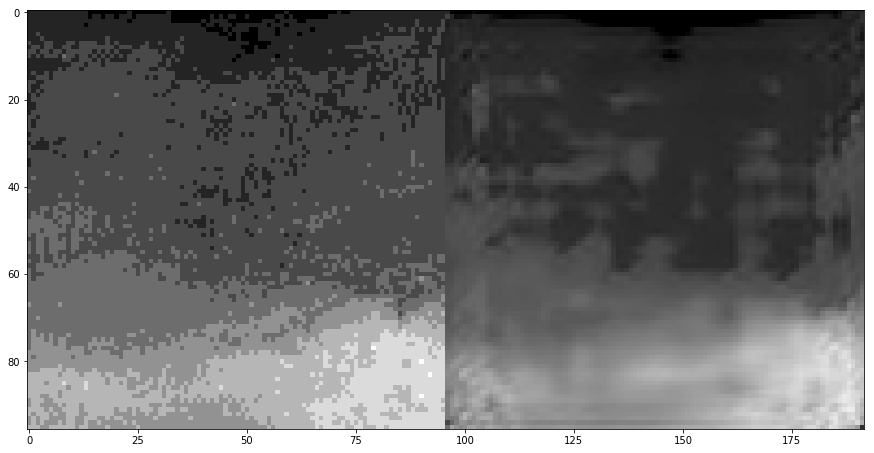

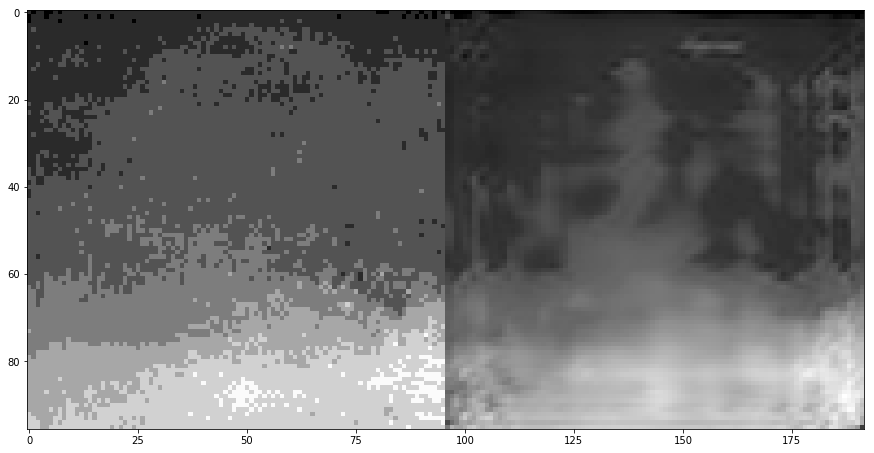

In [8]:
out = model( torch.tensor(X_val[0:10], dtype=torch.float).to(device) )

res = out.cpu().detach().numpy()
for i in range(10):
    mt.showImgGC(str(i).zfill(2),X_val[i,0,:,:],res[i,0,:,:],folder="",size=(15,30))

In [0]:
torch.save(model.state_dict(), "weights")
# !cp weights gdrive/My\ Drive/weights3

In [0]:
model.load_state_dict(torch.load("weights5"))

In [9]:
!zip fig.zip *.png
# !zip weights.zip weights*

  adding: 00.png (deflated 1%)
  adding: 01.png (deflated 0%)
  adding: 02.png (deflated 1%)
  adding: 03.png (stored 0%)
  adding: 04.png (deflated 0%)
  adding: 05.png (deflated 0%)
  adding: 06.png (deflated 0%)
  adding: 07.png (deflated 0%)
  adding: 08.png (deflated 2%)
  adding: 09.png (deflated 2%)


In [0]:
training.history = mt.fromCSV("history.csv")
training.history

In [0]:
from collections import defaultdict
import csv
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

def showImgGC(name,*img,folder=None,size=(30,30)):
    if len(img) == 0:
        return
    else:
        res = img[0]
        for i in img[1:]:
            res = np.concatenate((res,i),axis=1)
            
    fig, ax = plt.subplots(figsize=size)
    ax.grid(False)
    ax.imshow(res.squeeze(), cmap='binary_r')
    if folder is not None:
        res = (res * 255).astype('int')
        cv.imwrite(folder+name+".png",res)